In [552]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats

from datetime import date
from dateutil.relativedelta import relativedelta

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [553]:
inputdata1 = "../output_qt/combined_qt_data/"
outputdata1 = "../output_qt/regressiondata_qt/"

In [554]:
def get_data():
    get_data = pd.read_csv(inputdata1 + "a0_combinedQuarterly_extended_ARIMA.csv", parse_dates=[0], index_col=0)
    first_date = get_data.index[0]

    get_data.index = pd.date_range(first_date, get_data.index[-1], freq='QS').date
    return get_data

df = get_data()
df.tail()

,gdp_total,imports_goods_services,household_cons,gov_consumption,investments,gpd_invest_business_households,gov_invest,change_supply,exports_goods_services,gdp_total_deseasonalized,...,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8,Netherlands_GDP,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP
2023-07-01,228414.0,171477.0,102709.0,57861.0,44106.0,36472.000000,7632.000000,-645.0,195610.0,233430.0,...,196014.0,122579.000000,112442.000000,7.200000,176795.2,689738.0,509614.4,393025.900000,283945.8,94081.900000
2023-10-01,238600.0,173911.0,101295.0,62754.0,46748.0,39030.000000,7716.000000,757.0,200918.0,233920.0,...,199910.0,124838.000000,127017.000000,7.400000,184719.1,703189.3,538351.4,398428.400000,296525.9,103879.400000
2024-01-01,227490.0,169869.0,103451.0,56957.0,48067.0,41072.000000,6996.000000,-2696.0,191652.0,233310.0,...,197431.0,125942.305123,120632.655639,7.341663,174208.1,693329.4,524198.6,382821.000000,283422.3,97196.100000
2024-04-01,242922.0,177551.0,103869.0,62360.0,50843.0,43096.000000,7745.000000,-1752.0,205224.0,235834.0,...,200692.0,126997.736947,137205.067346,7.358679,187841.1,683600.1,524034.9,395044.700000,297267.4,101762.300000
2024-07-01,232265.0,177048.0,104280.0,59590.0,44121.0,40562.584779,7758.081766,-68.0,201137.0,237780.0,...,201462.0,128009.922911,119971.928640,7.353716,179833.7,683600.1,518764.8,391946.884709,295005.9,97783.024067


In [555]:

# subset of the data
df1 = df[[
        # 'gdp_total',
        # 'imports_goods_services',
        # 'household_cons',
        # 'gov_consumption', 
        # 'investments', 
        # 'gpd_invest_business_households',
        # 'gov_invest', 
        # 'change_supply', 
        # 'exports_goods_services',
        'gdp_total_deseasonalized', 
        'imports_goods_services_deseasonalized',
        'household_cons_deseasonalized', 
        'gov_consumption_deseasonalized',
        'investments_deseasonalized',
        'gpd_invest_business_households_deseasonalized',
        'gov_invest_deseasonalized', 
        'change_supply_deseasonalized',
        'exports_goods_services_deseasonalized',
        'BeloningSeizoengecorrigeerd_2', 
        'Loonkosten_7',
        'BeloningVanWerknemers_8', 
        'Germany_GDP',
        'France_GDP', 
        'Italy_GDP', 
        'Spain_GDP', 
        'Belgium_GDP' 
        ]]

### Start date

In [556]:
df1.index = pd.DatetimeIndex(df1.index)
start_date_analysis = '1996-01-01'  
save_some_data_for_predictions ='2024-07-01'

df1 = df1.loc[start_date_analysis:save_some_data_for_predictions,:]

### Save transformations of GDP

In [557]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))


GDP_TRANSFORMATIONS = df1.loc[:,['gdp_total']].copy()
GDP_TRANSFORMATIONS.index = pd.DatetimeIndex(GDP_TRANSFORMATIONS.index)

### Add 'sure' data and random data

In [558]:

# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

# trend
df1['trend'] = [i for i in range(0, len(df1))]

print(df1.shape)

(115, 22)


### Drop if number of observations less than GDP

In [559]:
def dropifObsLessThanGDP(data):

    describe = data.describe()
    descr = describe.loc['count',:].sort_values(ascending=True)

    # Drop columns with values less than gdp_total
    gdpObservations = descr['gdp_total']

    cols = descr[descr < gdpObservations].index.tolist()
    print(cols)

    data.drop(columns=cols, inplace=True)

    return data
    

df1 = dropifObsLessThanGDP(df1)

[]


### Log and scale data

In [560]:
# scale data to make comparable

def log_data(data,seasonal_only = True):

    if seasonal_only:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply_deseasonalized'])])
        df2['change_supply_deseasonalized']= data['change_supply_deseasonalized']
        data = df2.copy()

    else:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply', 'change_supply_deseasonalized'])])
        df2['change_supply']= data['change_supply']
        df2['change_supply_deseasonalized']= data['change_supply_deseasonalized']
        data = df2.copy()

    return data

#df1 = log_data(df1, seasonal_only=True)

### Standard Scaler

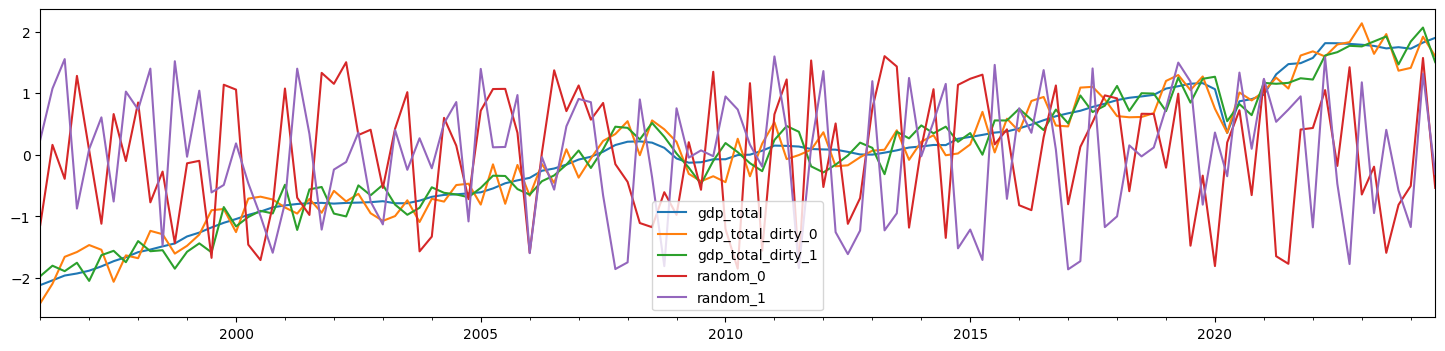

In [561]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()


#############################
GDP_TRANSFORMATIONS['gdp_total_scaled'] = scaled_features_df.loc[:, ['gdp_total']]

In [562]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [563]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:100,:]
    kw_test1['Qts'] = [1,2,3,4] * int(len(kw_test1)/4)
    kw_test1['Semi'] = [1,2] * int(len(kw_test1)/2)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

(115, 22)


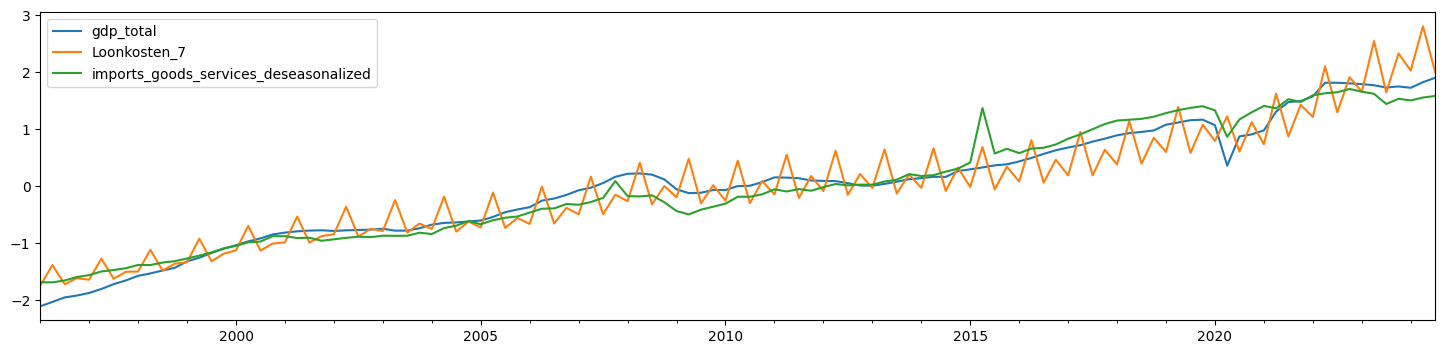

In [564]:
scaled_features_df[['gdp_total', 'Loonkosten_7', 'imports_goods_services_deseasonalized']].plot()

print(df1.shape)

In [565]:
def Kruskal_Wallis_Qt(data, STORE_FOR_TESTS): # Quarterly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Qts'].unique():
            res.append(data[data['Qts'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Qt_Seasonality'] = 'No_Qt_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Qt_Seasonality'] = 'Qt_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Qt(kw1, STORE_FOR_TESTS)

In [566]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Semi yearly
    
    for col in data.columns:
        # no need to test
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [567]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)
scaled_features_df.dropna(inplace=True)

deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index
print(deseasonalizeThese)

for i in deseasonalizeThese:

    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=4, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=4, extrapolate_trend='freq')
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df.loc['2024-07-01':]


Index(['change_supply_deseasonalized', 'Loonkosten_7', 'France_GDP',
       'Italy_GDP', 'Spain_GDP', 'Belgium_GDP', 'random_0', 'random_1'],
      dtype='object')


,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,...,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1,trend
2024-07-01,1.898616,1.579412,1.911728,1.881331,1.490681,1.56977,0.833069,-2.750667,1.626501,2.406854,...,1.333219,1.663207,1.655281,1.793466,1.725494,1.601213,1.504484,-1.251879,-0.19918,1.717054


[ 1  2  3  6  7  8 10 13 14 16 17]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningSeizoengecorrigeerd_2', 'BeloningVanWerknemers_8', 'Italy_GDP', 'Spain_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


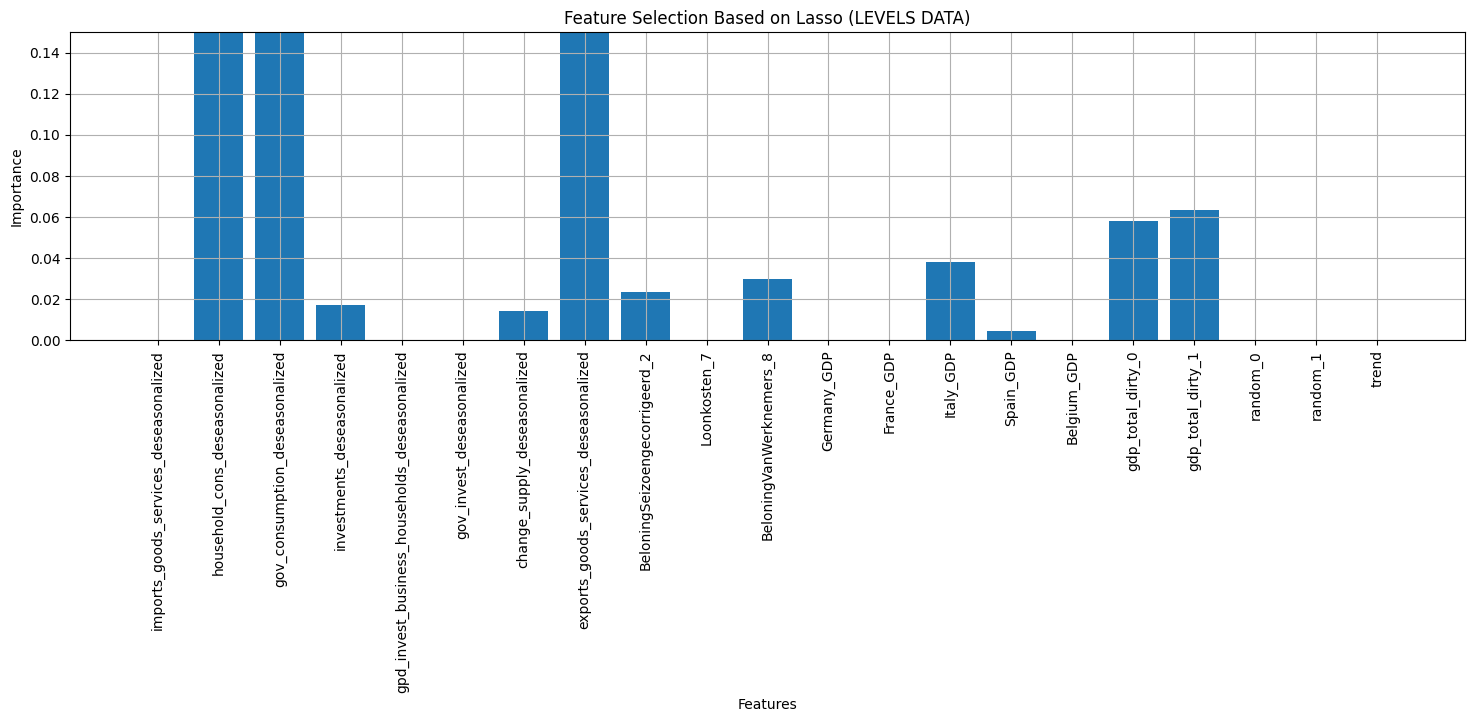

(115, 22)


In [568]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.01, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'gov_invest_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningSeizoengecorrigeerd_2', 'Loonkosten_7', 'BeloningVanWerknemers_8', 'Germany_GDP', 'France_GDP', 'Italy_GDP', 'Spain_GDP', 'Belgium_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'trend']


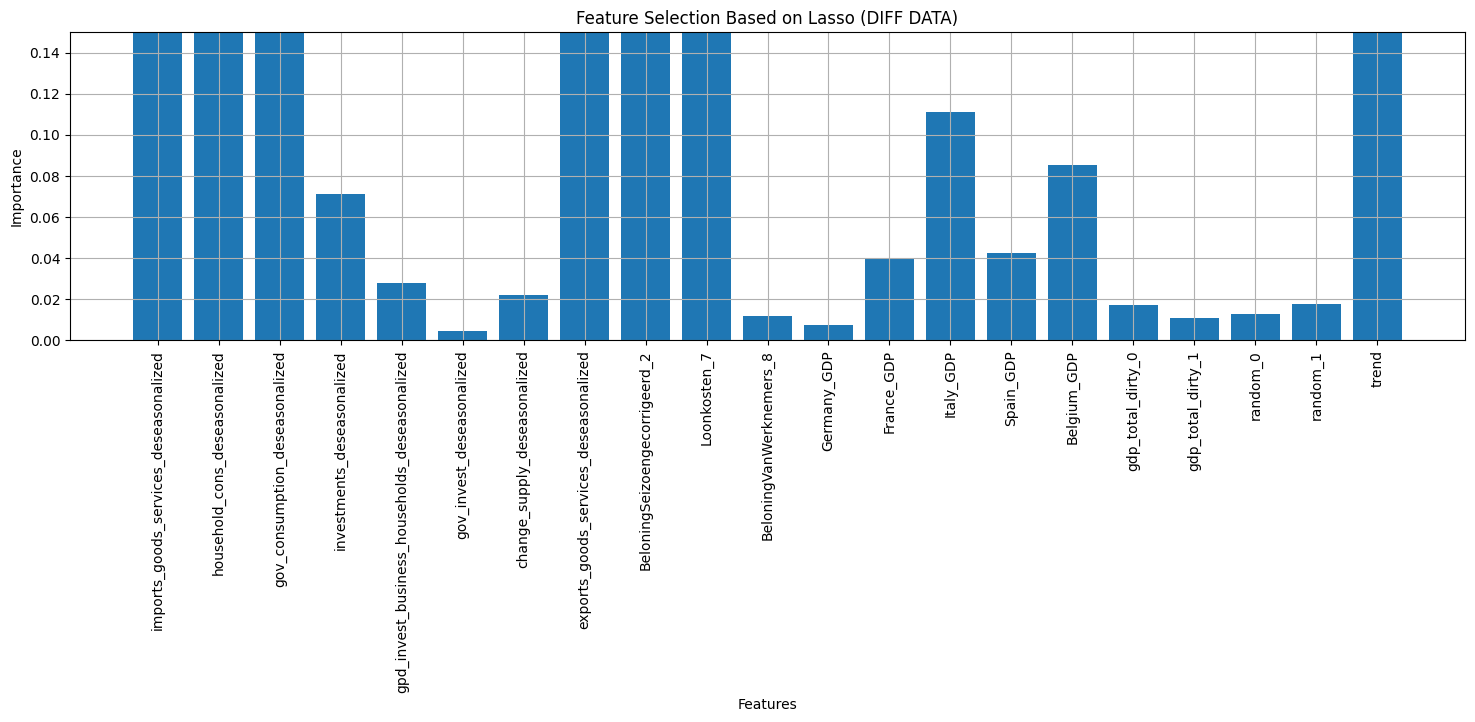

['imports_goods_services_deseasonalized',
 'household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'investments_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'gov_invest_deseasonalized',
 'change_supply_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningSeizoengecorrigeerd_2',
 'Loonkosten_7',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'France_GDP',
 'Italy_GDP',
 'Spain_GDP',
 'Belgium_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'trend']

In [569]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [570]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty_0', 'gdp_total_dirty_1','random_0', 'random_1'] + selectThese 
df_lag = df[selectThese]

print(df_lag.shape)


(115, 27)


[ 0  1  5  6  7  8 10 11 14 15 16 17 18 21 23 24 25]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'imports_goods_services_deseasonalized_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_consumption_deseasonalized_lag_1', 'investments_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'Loonkosten_7_lag_1', 'BeloningVanWerknemers_8_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'random_0_lag_1', 'random_1_lag_1', 'trend_lag_1']


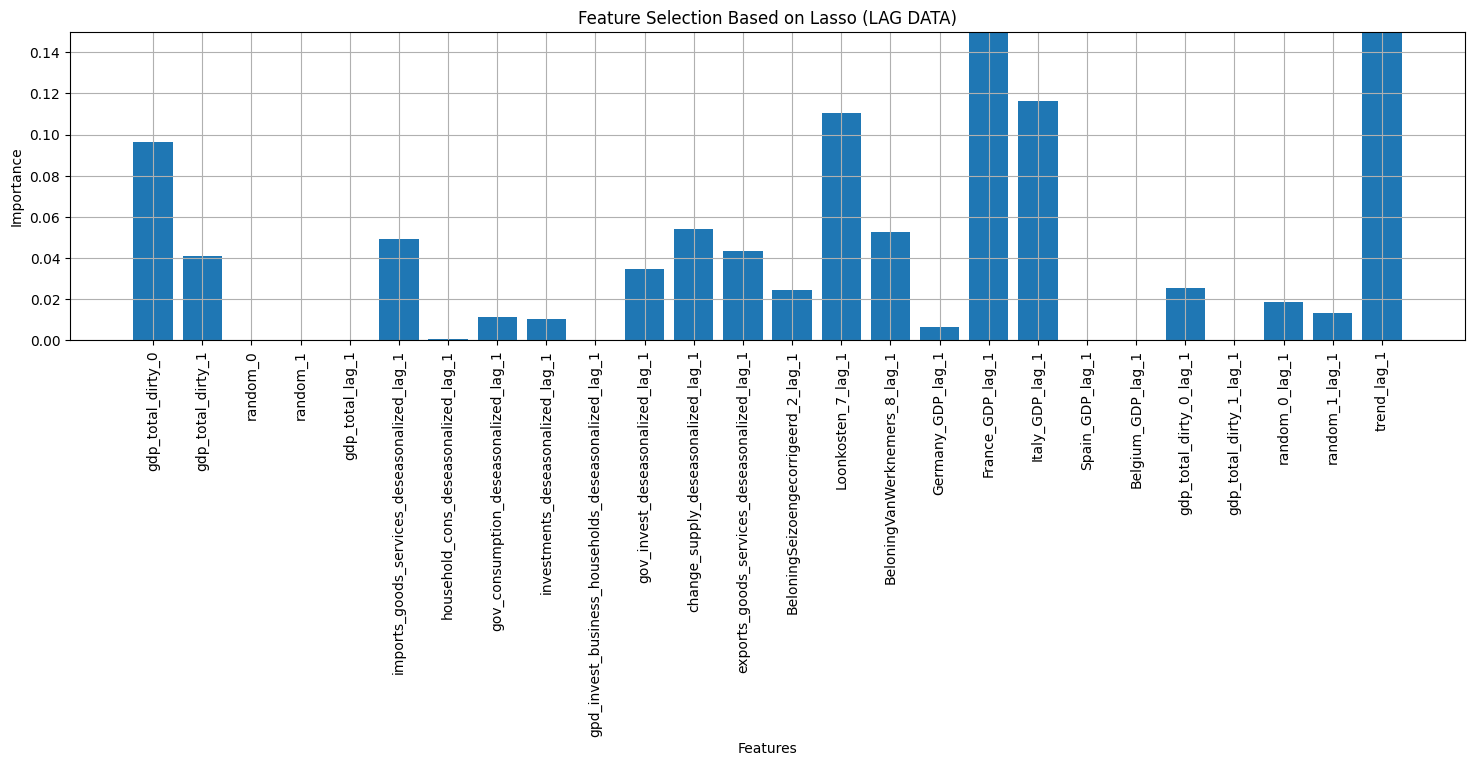

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'imports_goods_services_deseasonalized_lag_1',
 'household_cons_deseasonalized_lag_1',
 'gov_consumption_deseasonalized_lag_1',
 'investments_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'Loonkosten_7_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'random_0_lag_1',
 'random_1_lag_1',
 'trend_lag_1']

In [571]:
lassoreg(df_lag, alpha=0.001, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  2  3  4  6  7 10 11 13 16 17 18 19]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


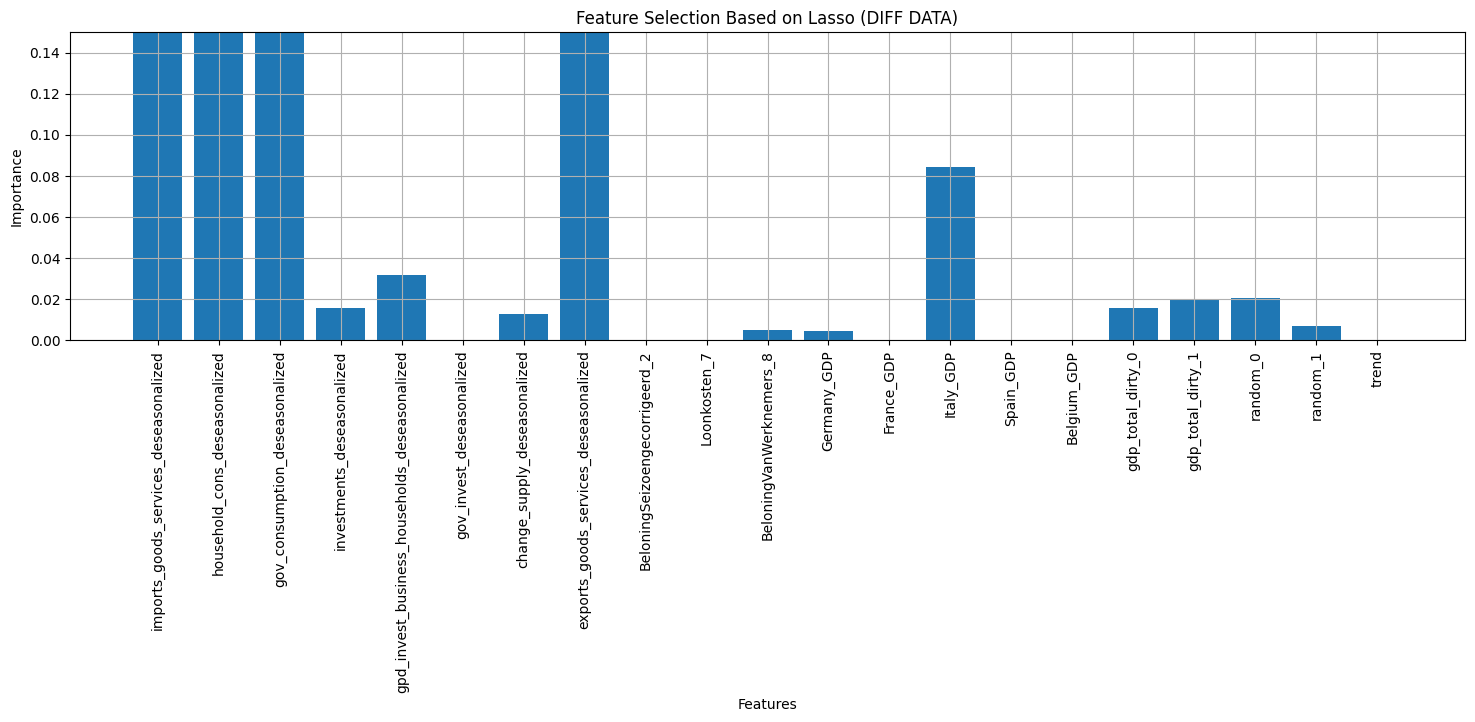

In [572]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (DIFF DATA)'); 

[ 0  1  2  6  8 10 15 16 17 18 21]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'household_cons_deseasonalized_lag_1', 'investments_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'BeloningVanWerknemers_8_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'gdp_total_dirty_0_lag_1']


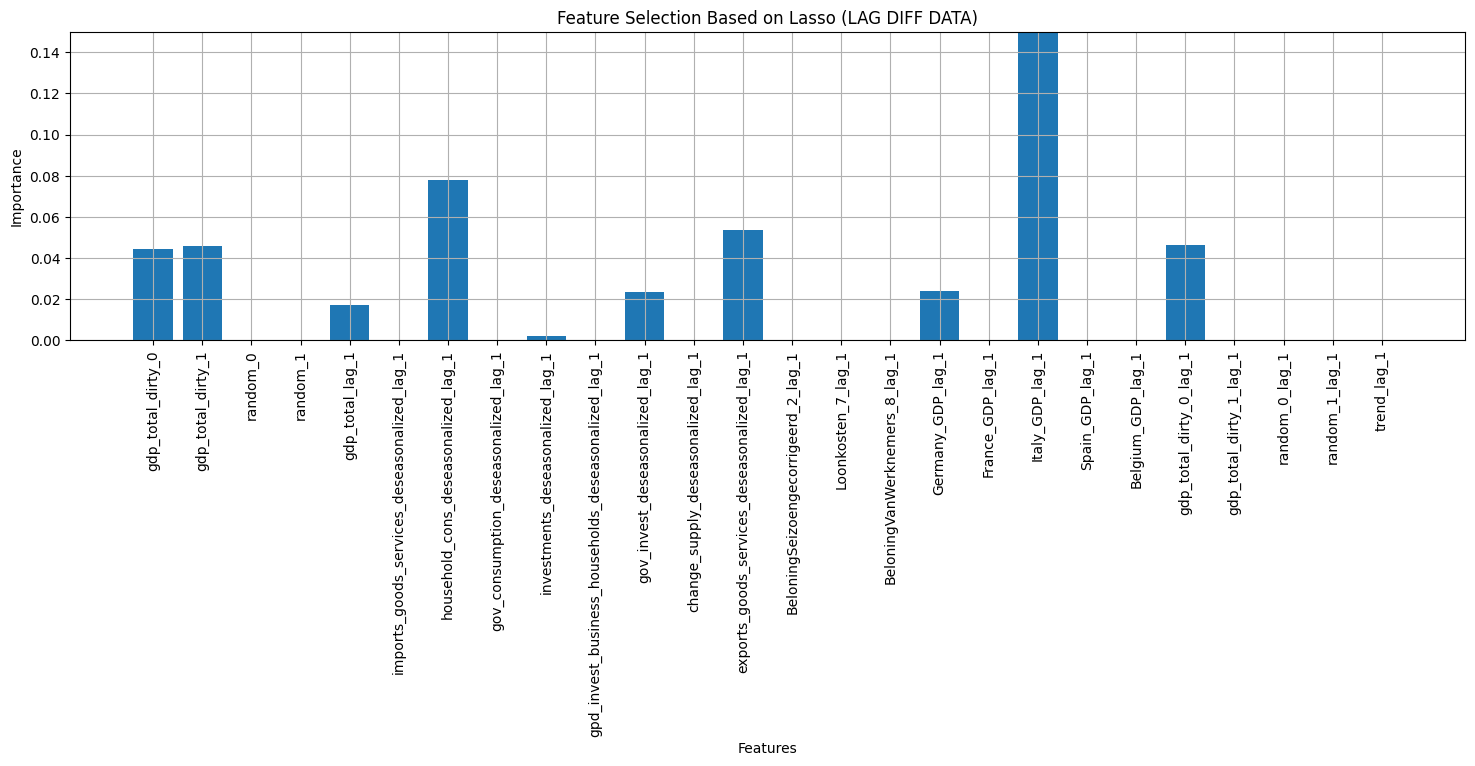

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'household_cons_deseasonalized_lag_1',
 'investments_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'gdp_total_dirty_0_lag_1']

In [573]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 


### Make sure data is stationary

In [574]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [575]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [576]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)


(22, 3)


### If not stationary, difference, then test for stationarity again

In [577]:

def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

GDP_TRANSFORMATIONS['gdp_total_scaled_diff'] = scaled_features_df_diff.loc[:, ['gdp_total']]

print(scaled_features_df_diff.shape)


(115, 22)


In [578]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data
gdp_total,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
imports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
household_cons_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_consumption_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
investments_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gpd_invest_business_households_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_invest_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
change_supply_deseasonalized,No_Qt_Seasonality,Semi_Seasonality,NotStationary,Stationary,True
exports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
BeloningSeizoengecorrigeerd_2,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,NotStationary,True


<Axes: >

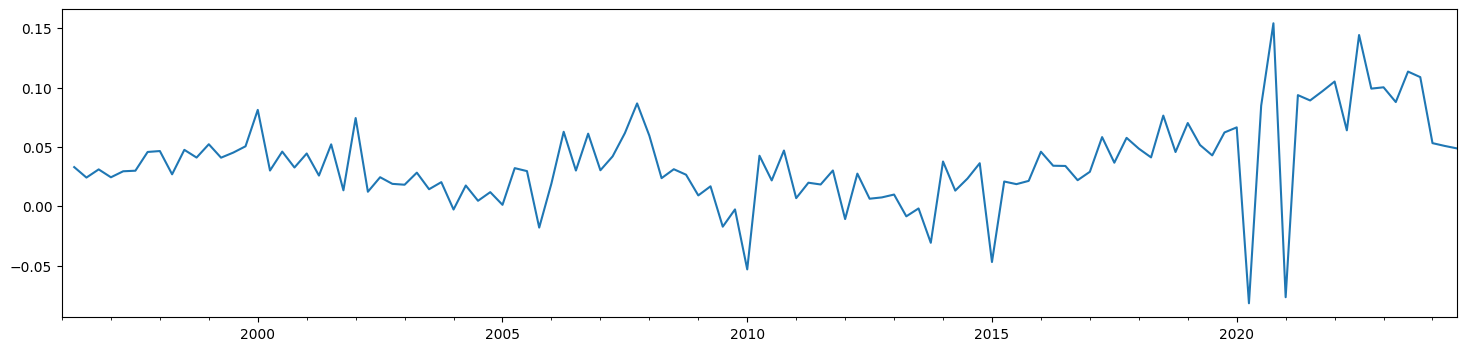

In [579]:
scaled_features_df_diff['BeloningSeizoengecorrigeerd_2'].plot()

[ 1  2  4  7 10 11 13 16 17 19]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_1']


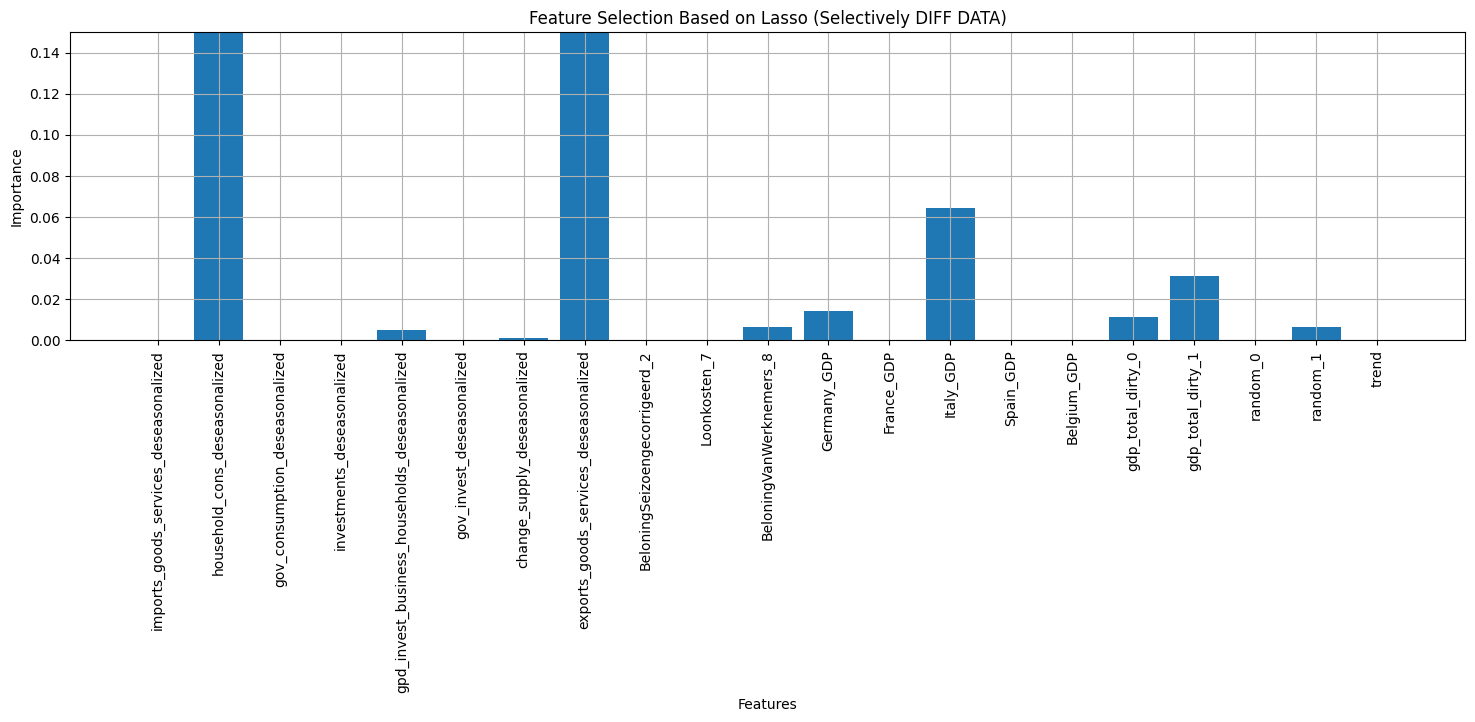

['household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'Italy_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_1']

In [580]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(115, 22)


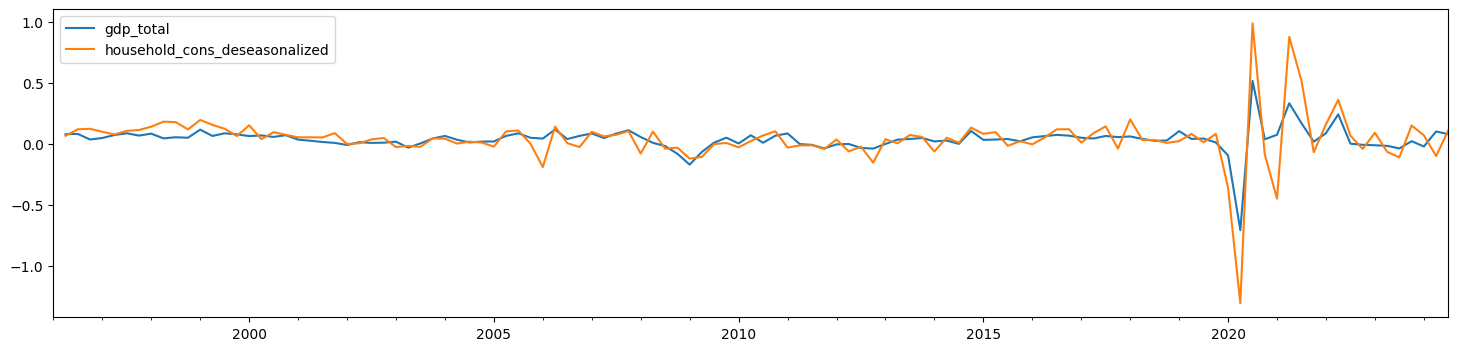

In [581]:
scaled_features_df_diff[['gdp_total', 'household_cons_deseasonalized']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [582]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(115, 44)


In [583]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]


In [584]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(115, 19)


[ 2  6 11 12 13 14]
['household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'BeloningVanWerknemers_8_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1']


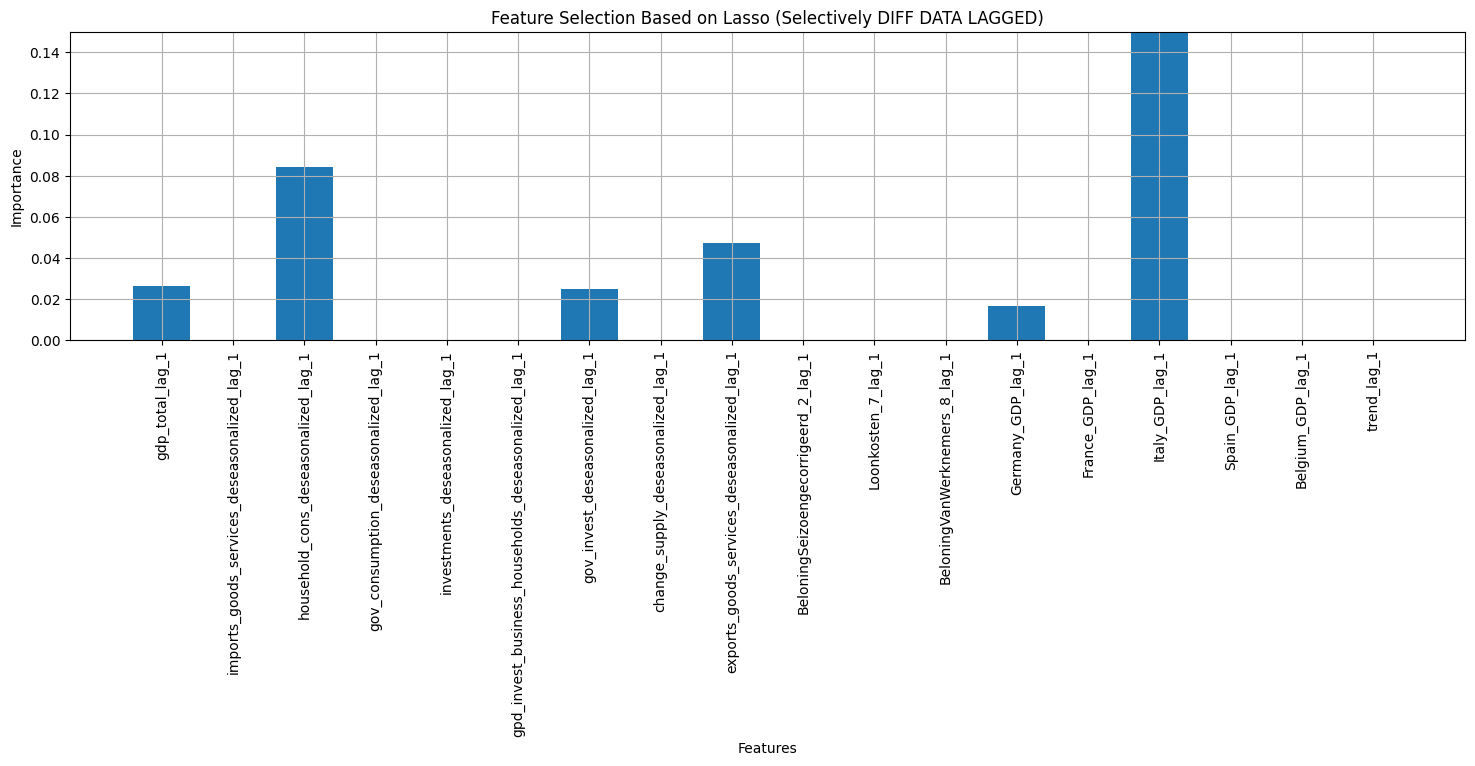

In [585]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

,gdp_total,household_cons_deseasonalized_lag_1,gov_invest_deseasonalized_lag_1,BeloningVanWerknemers_8_lag_1,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1
1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,0.076770,NaN,NaN,NaN,NaN,NaN,NaN
1996-07-01,0.078696,0.063677,0.690954,-0.233755,0.157322,0.044249,0.068191
1996-10-01,0.033098,0.116654,0.035987,-0.116877,0.169271,0.050930,0.090167
1997-01-01,0.045598,0.120617,0.315488,-0.155836,0.150351,0.030041,0.023388
...,...,...,...,...,...,...,...
2023-07-01,-0.040055,-0.068433,-0.214723,-0.038959,-0.261870,0.031309,0.000869
2023-10-01,0.019261,-0.112690,0.338279,-0.272714,0.172256,0.042675,0.001586
2024-01-01,-0.023978,0.148096,-0.277101,0.077918,0.205116,0.032499,0.018894
2024-04-01,0.099215,0.067112,-0.189532,-0.022727,-0.150351,0.032970,0.011105


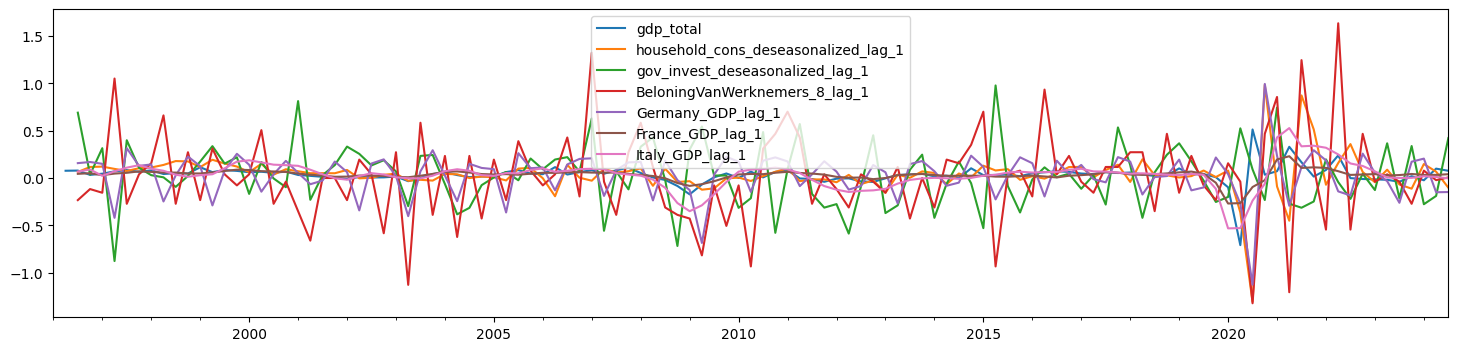

In [586]:
chooseThese = ['gdp_total'] + lasout
scaled_features_df_diff_lag[chooseThese].plot()
scaled_features_df_diff_lag[chooseThese]

<Axes: >

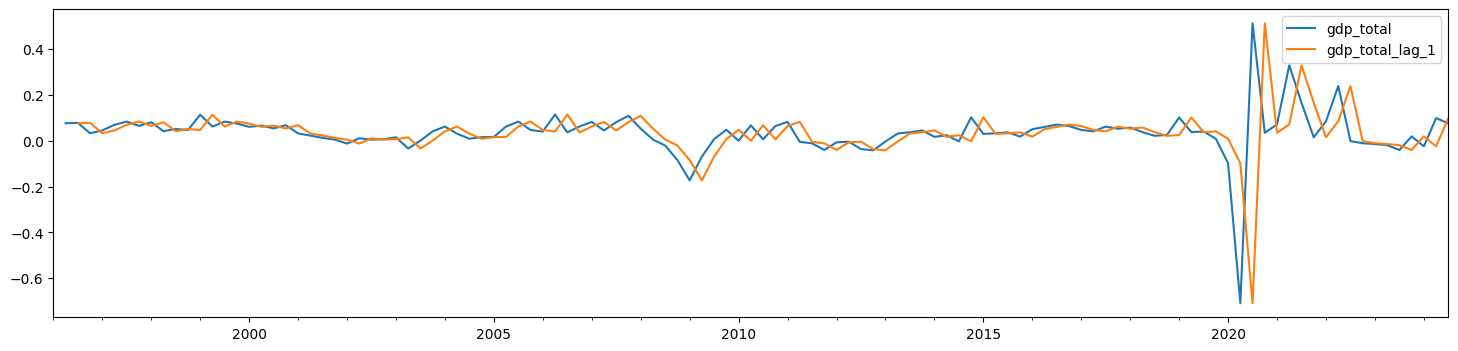

In [587]:
scaled_features_df_diff_lag[['gdp_total','gdp_total_lag_1']].plot()

In [588]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")

reg1.dropna(inplace=True)

##################################
test_start_date = start_date_analysis
end_test_date = '2024-03-01'
##################################

X = reg1.loc[test_start_date:end_test_date, chooseThese[1]:]
X = sm.add_constant(X)

y_true = reg1.loc[test_start_date:end_test_date:, 'gdp_total']

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     12.75
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           9.56e-11
Time:                        14:07:30   Log-Likelihood:                 126.77
No. Observations:                 111   AIC:                            -239.5
Df Residuals:                     104   BIC:                            -220.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

<Axes: >

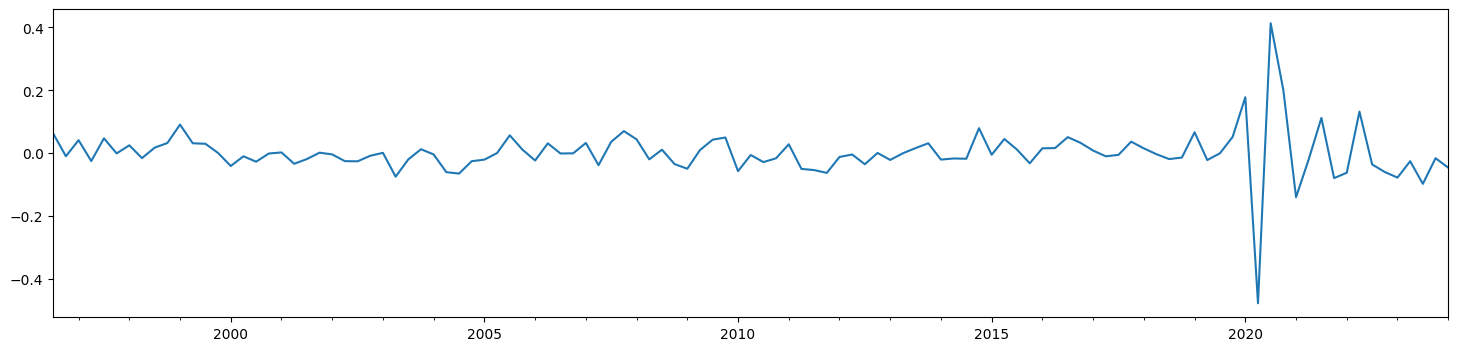

In [589]:
results.resid.plot()

<Axes: >

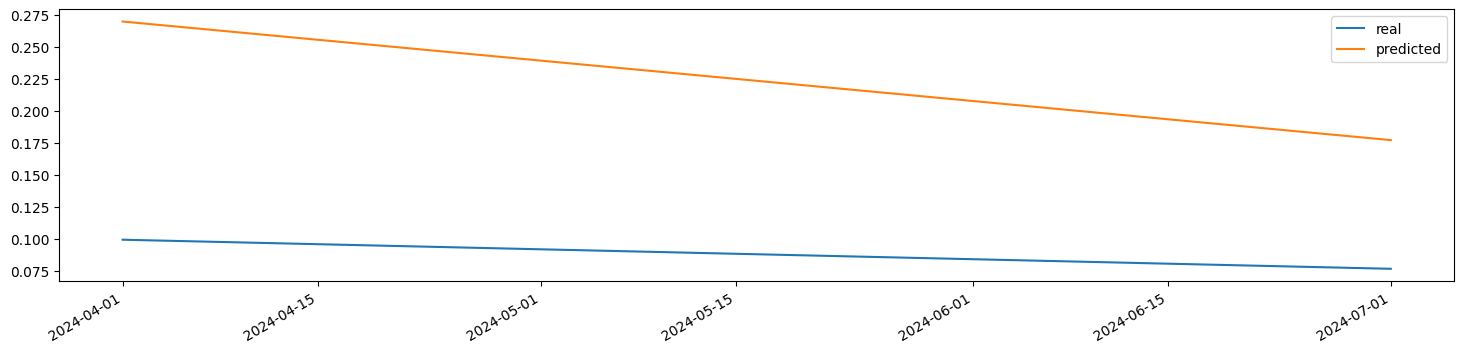

In [590]:
ypred = results.predict(X)
Xnew = reg1.loc[end_test_date:, chooseThese[1]:]
Xnew[['const']] = 1
reg1.loc[end_test_date:, ['gdp_total']]

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.loc[end_test_date:, 'gdp_total'], 'predicted': ynewpred})
df_pred.plot()


Homoskedasticity (Breusch-Pagan)


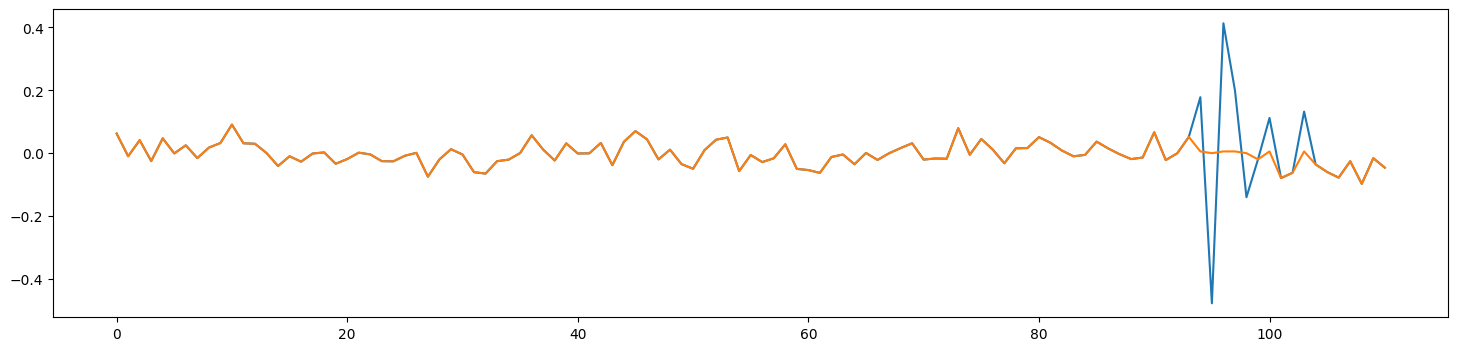

In [591]:

plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Remove Covid for tests
results.resid[results.resid < -0.10] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)
### Homoskedasticity
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

In [592]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Homoskedasticity (White)


### Colinearity

In [593]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

1.4189450231189535
Positive autocorrelation is significant


### Normality

Residuals are normally distributed


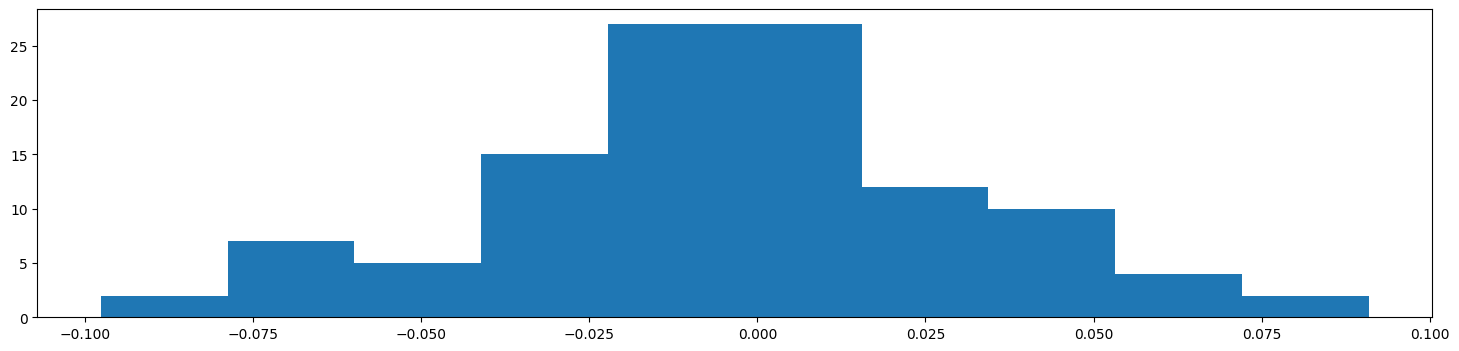

In [594]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=10);

In [595]:
def test_reverse_transform(start_date_analysis, my_data_to_untransform):

    GDP_StandardScaler_STD = np.std(GDP_TRANSFORMATIONS['gdp_total'])
    GDP_StandardScaler_MEAN = np.mean(GDP_TRANSFORMATIONS['gdp_total'])

    def diff_inv_Transformation(df_diff, first_value):
        series_inverted = np.r_[first_value, df_diff].cumsum().astype('float64')
        return series_inverted

    def std_inv_Transformation(data, std = GDP_StandardScaler_STD, mean = GDP_StandardScaler_MEAN):  
        return data * std + mean


    data_to_untransform = my_data_to_untransform
    date_start_difference = pd.to_datetime(start_date_analysis) 

    test1 = std_inv_Transformation(diff_inv_Transformation(data_to_untransform, GDP_TRANSFORMATIONS.loc[date_start_difference, 'gdp_total_scaled']))

    return test1

tes1 = test_reverse_transform(start_date_analysis, y_true)


In [596]:
# create new column with existing data from gdp_total_scaled_diff, then replace with predictions values
GDP_TRANSFORMATIONS["predicts_before_transformations"] = GDP_TRANSFORMATIONS['gdp_total_scaled_diff']
GDP_TRANSFORMATIONS.loc[end_test_date:, 'predicts_before_transformations'] = ynewpred

GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff,predicts_before_transformations
1996-01-01,135716.0,-2.113368,NaN,NaN
1996-04-01,137669.0,-2.036599,0.076770,0.076770
1996-07-01,139671.0,-1.957903,0.078696,0.078696
1996-10-01,140513.0,-1.924805,0.033098,0.033098
1997-01-01,141673.0,-1.879208,0.045598,0.045598
...,...,...,...,...
2023-07-01,233430.0,1.727624,-0.040055,-0.040055
2023-10-01,233920.0,1.746885,0.019261,0.019261
2024-01-01,233310.0,1.722907,-0.023978,-0.023978
2024-04-01,235834.0,1.822122,0.099215,0.269726


<Axes: >

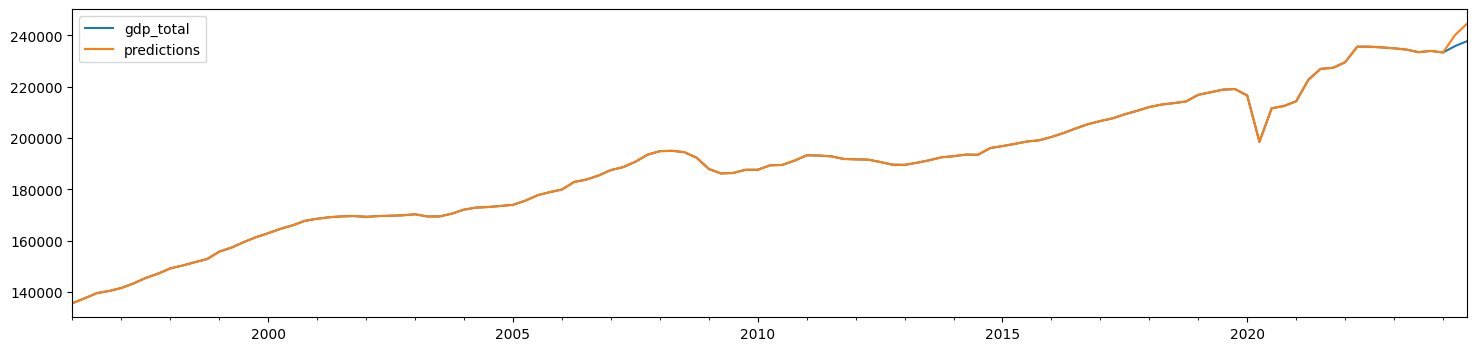

In [597]:
predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].dropna().values)
GDP_TRANSFORMATIONS['predictions'] = predictions

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()

In [598]:
GDP_TRANSFORMATIONS

,gdp_total,gdp_total_scaled,gdp_total_scaled_diff,predicts_before_transformations,predictions
1996-01-01,135716.0,-2.113368,NaN,NaN,135716.000000
1996-04-01,137669.0,-2.036599,0.076770,0.076770,137669.000000
1996-07-01,139671.0,-1.957903,0.078696,0.078696,139671.000000
1996-10-01,140513.0,-1.924805,0.033098,0.033098,140513.000000
1997-01-01,141673.0,-1.879208,0.045598,0.045598,141673.000000
...,...,...,...,...,...
2023-07-01,233430.0,1.727624,-0.040055,-0.040055,233430.000000
2023-10-01,233920.0,1.746885,0.019261,0.019261,233920.000000
2024-01-01,233310.0,1.722907,-0.023978,-0.023978,233310.000000
2024-04-01,235834.0,1.822122,0.099215,0.269726,240171.773991


<Axes: >

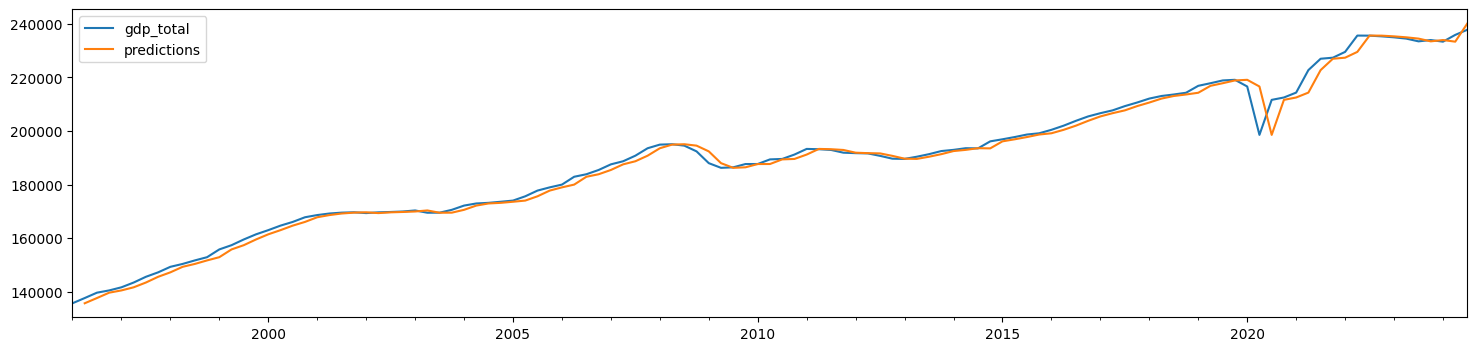

In [599]:

predictions = test_reverse_transform(start_date_analysis, GDP_TRANSFORMATIONS['predicts_before_transformations'].values[1:-1])
GDP_TRANSFORMATIONS['predictions'] = np.append(np.nan, predictions)

GDP_TRANSFORMATIONS[['gdp_total', 'predictions']].plot()